In [125]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from tqdm import tqdm
import FEAutils as hlp

In [19]:
s_our_carbon_intensity_ts = pd.read_csv('../data/gb_carbon_intensity.csv').set_index('datetime')['gb_carbon_intensity_gco2_per_kwh']
s_our_carbon_intensity_ts.index = pd.to_datetime(s_our_carbon_intensity_ts.index)

s_our_carbon_intensity_ts.head()

datetime
2015-10-04 23:00:00+00:00    222.592849
2015-10-04 23:30:00+00:00    215.705716
2015-10-05 00:00:00+00:00    219.275039
2015-10-05 00:30:00+00:00    224.838007
2015-10-05 01:00:00+00:00    217.278694
Name: gb_carbon_intensity_gco2_per_kwh, dtype: float64

In [20]:
construct_ei_year_url = lambda year: f'https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_{year}.csv'

def retrieve_ei_df(
    start_year: int=2009, 
    end_year: int=2021
):
    ei_dfs = []

    for year in tqdm(range(start_year, end_year+1)):
        ei_year_url = construct_ei_year_url(year)
        df_ei_year = pd.read_csv(ei_year_url)
        ei_dfs += [df_ei_year]

    df_ei = pd.concat(ei_dfs)

    df_ei['local_datetime'] = pd.to_datetime(df_ei['local_datetime'], utc=True)
    df_ei = df_ei.set_index('local_datetime')
    
    df_ei = df_ei[~df_ei.index.duplicated()]
    
    return df_ei

In [42]:
df_ei = retrieve_ei_df()

s_ei_carbon_intensity_ts = df_ei.loc[s_carbon_intensity_ts.index, 'gCO2_per_kWh']

s_ei_carbon_intensity_ts.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.30it/s]


datetime
2015-10-04 23:00:00+00:00    254.0
2015-10-04 23:30:00+00:00    250.0
2015-10-05 00:00:00+00:00    258.0
2015-10-05 00:30:00+00:00    266.0
2015-10-05 01:00:00+00:00    258.0
Name: gCO2_per_kWh, dtype: float64

In [129]:
# retrieve data in 4-wk batches
get_ng_ci_url = lambda start_date, end_date: f'https://api.carbonintensity.org.uk/intensity/{start_date.strftime("%Y-%m-%d")}T00:00Z/{end_date.strftime("%Y-%m-%d")}T23:30Z'

df_ng_ci = pd.DataFrame()

for start_date in tqdm(pd.date_range('2017-09-11', '2021-10-01', freq='28D')):
    end_date = start_date + pd.Timedelta('27D')
    ng_ci_month_url = get_ng_ci_url(start_date, end_date)
    df_ng_ci_month = pd.DataFrame(requests.get(ng_ci_month_url).json()['data'])
    df_ng_ci = df_ng_ci.append(df_ng_ci_month)

df_ng_ci = df_ng_ci.reset_index(drop=True).drop_duplicates(subset=['from', 'to'])

df_ng_ci.head()

,from,to,intensity
0,2017-09-11T23:00Z,2017-09-11T23:30Z,"{'forecast': 134, 'actual': 140, 'index': 'low'}"
1,2017-09-11T23:30Z,2017-09-12T00:00Z,"{'forecast': 143, 'actual': 144, 'index': 'low'}"
2,2017-09-12T00:00Z,2017-09-12T00:30Z,"{'forecast': 137, 'actual': 142, 'index': 'low'}"
3,2017-09-12T00:30Z,2017-09-12T01:00Z,"{'forecast': 134, 'actual': 140, 'index': 'low'}"
4,2017-09-12T01:00Z,2017-09-12T01:30Z,"{'forecast': 133, 'actual': 139, 'index': 'low'}"


In [ ]:
# for mixed I should then use avg fuel

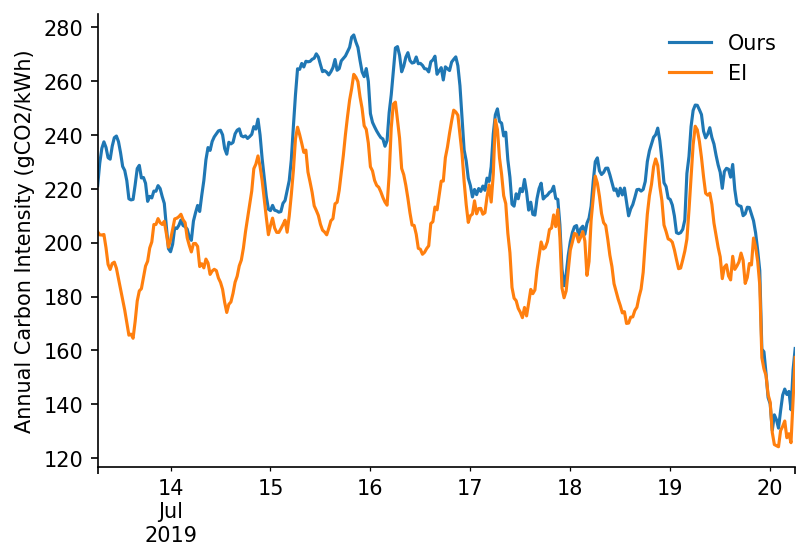

In [146]:
offset = int(s_our_carbon_intensity_ts.size * np.random.rand())

fig, ax = plt.subplots(dpi=150)

s_our_carbon_intensity_ts.iloc[offset:offset+48*7].plot(label='Ours')
s_ei_carbon_intensity_ts.iloc[offset:offset+48*7].plot(label='EI')

ax.set_xlabel('')
ax.set_ylabel('Annual Carbon Intensity (gCO2/kWh)')
hlp.hide_spines(ax)
ax.legend(frameon=False)

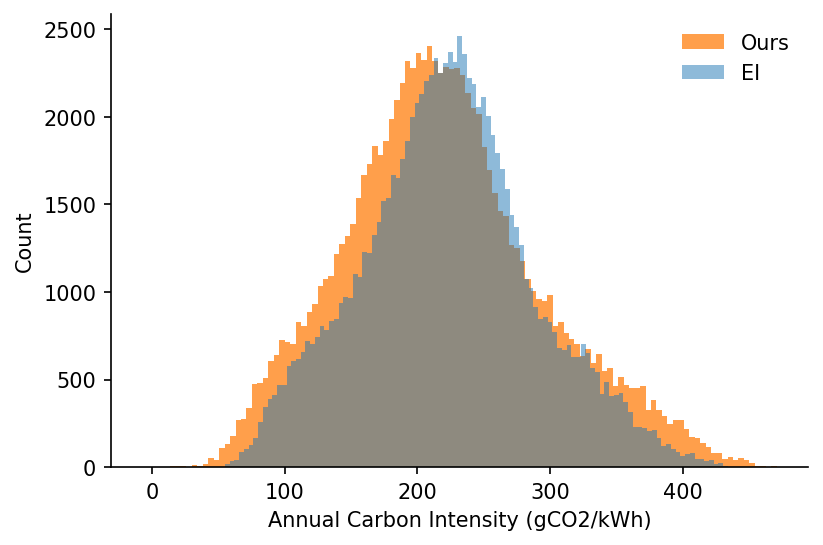

In [40]:
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_ei_carbon_intensity_ts, label='Ours', ax=ax, color='C1', fill=True, linewidth=0)
sns.histplot(s_our_carbon_intensity_ts, label='EI', ax=ax, color='C0', fill=True, linewidth=0, alpha=0.5)

ax.set_xlabel('Annual Carbon Intensity (gCO2/kWh)')
hlp.hide_spines(ax)
ax.legend(frameon=False)

In [111]:
mean_abs_diff = (s_ei_carbon_intensity_ts-s_our_carbon_intensity_ts).abs().mean()
abs_pct_diff = (s_ei_carbon_intensity_ts-s_our_carbon_intensity_ts).abs().divide(s_our_carbon_intensity_ts).mean()

print(f'Mean absolute difference: {mean_abs_diff:.2f} (gCO2/kWh)\nAbsolute percentage difference: {100*abs_pct_diff:.2f}%')

Mean absolute difference: 18.75 (gCO2/kWh)
Absolute percentage difference: 8.91%
